## Creation of benchmark N-body NFW MW-type halo via sampling.

In [ ]:
from shared.preface import *
import shared.functions as fct

PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=20, thetas=20, vels=200,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)

# Determine number of DM particles to sample based on virial mass.
DM_mass = 1437874.875*Msun  # from 25 Mpc box
num_DM_MW = math.floor(Mvir_MW / DM_mass)  # ~1.4 mio.
num_DM_box = 235953  # a halo from sim box

Mvir_box = num_DM_box*DM_mass

def halo_sample(z, snap, Mvir_init, R_s_init, rho0_init, DM_mass_Msun, out_dir):

    # R_200 of MW-type halo at redshift 0.
    R_200_MW = (Mvir_MW / (200 * fct.rho_crit(0) * 4.*Pi/3.))**(1./3.)
    
    # Determine R_200 and c_200 and scale radius at redshift z.
    R_200 = (Mvir_init / (200 * fct.rho_crit(z) * 4.*Pi/3.))**(1./3.)
    c_200 = fct.c_vir(z, Mvir_init, R_200_MW, R_s_init)

    # Calculate virial mass at redshift z and with it number of DM particles.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    M_200 = 4*Pi*rho0_init*Rs_MW**3 * f_200
    num_DM = math.floor(M_200/DM_mass_Msun)

    # Construct projection function.
    def Proj(r, r_s, f_norm):
        x = r/r_s
        f_r = np.log(1+x) - (x/(1+x))
        return f_r/f_norm

    # Construct inverse function. Needs to be without numerical units.
    invf = inversefunc(Proj, args=(Rs_MW/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian coordinates.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z))

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)

## Inverting procedure for each redshift (multiprocess), with R_vir.

In [10]:
from shared.preface import *
import shared.functions as fct

PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=20, thetas=20, vels=200,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 20, THETAs=20, Vs=200
Total neutrinos: 80000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 1000
DM mass of sim box in log10 Msun: 6.1577
Smoothening length of sim box in kpc: 0.65
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************


In [ ]:
# Determine number of DM particles to sample, which is fixed for all redshifts.
num_DM_MW = math.floor(Mvir_MW / PRE.DM_SIM_MASS)  # ~1.4 mio.
num_DM_box = 235953  # a halo from sim box

def halo_sample_z(z, snap, num_DM, Mvir_z0, Rvir_z0, Rs_z0, out_dir):

    # Determine values of virial radius, concentration and scale radius.
    R_vir = fct.R_vir_fct(z, Mvir_z0)
    c_vir = fct.c_vir(z, Mvir_z0, Rvir_z0, Rs_z0)
    R_s = R_vir / c_vir

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_vir = np.log(1+c_vir) - (c_vir/(1+c_vir))
    invf = inversefunc(Proj, args=(R_s/kpc, f_vir))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian coordinates.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z))

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)

In [21]:
with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, PRE.ZEDS_SNAPS[::-1], PRE.NUMS_SNAPS[::-1],
        repeat(num_DM_MW), repeat(Mvir_MW), repeat(Rvir_MW), repeat(Rs_MW), 
        repeat(PRE.OUT_DIR)
    )

### Check/plot a couple of sampled halos.

1411805
1411805
1411805
1411805


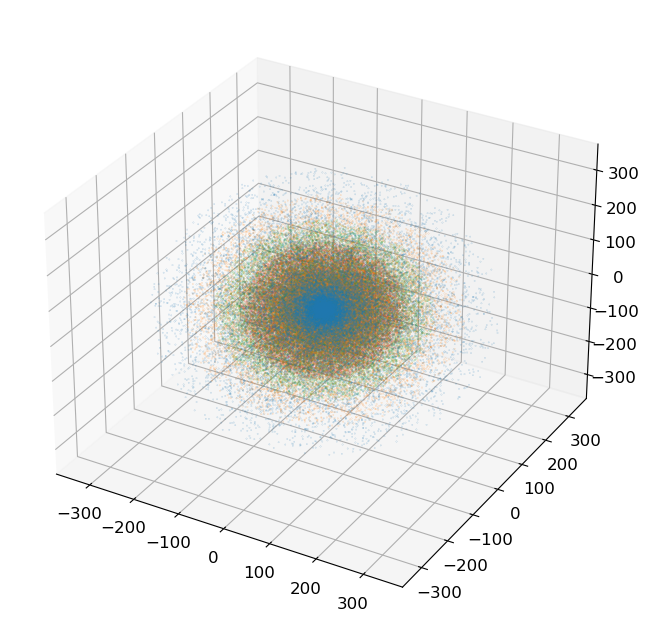

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for snap in PRE.NUMS_SNAPS[::-1][[0, 5, 10, 15]]:
    coords = np.load(f'{PRE.OUT_DIR}/benchmark_halo_snap_{snap}.npy')
    print(len(coords))
    ss = 50
    x, y, z = coords[:,0][::ss], coords[:,1][::ss], coords[:,2][::ss]
    ax.scatter(x,y,z, alpha=0.8, s=0.01)

plt.show()

## Inverse function only for z=0, then rescale, using R_200.

In [ ]:
### ------------------ ###
### Do it once for z=0 ###
### ------------------ ###

# Determine number of DM particles to sample based on virial mass.
DM_mass = 1437874.875*Msun  # from 25 Mpc box
# num_DM_MW = math.floor(Mvir_MW / DM_mass)  # ~1.4 mio.
num_DM = 235953  # a halo from sim box
Mvir_box = num_DM*DM_mass

# Determine evolution of virial radius, concentration and scale radius.
zeds = PRE.ZEDS_SNAPS[::-1]
R_vir = np.array([fct.R_vir_fct(z, Mvir_MW) for z in zeds])
c_vir = np.array([fct.c_vir(z, Mvir_MW, Rvir_MW, Rs_MW) for z in zeds])
R_s = R_vir / c_vir

# Construct projection function.
def Proj(x, f_norm):
    f_r = np.log(1+x) - (x/(1+x))
    return f_r/f_norm

f_vir = np.log(1+c_vir) - (c_vir/(1+c_vir))
f_vir_z0 = np.log(1+c_vir[0]) - (c_vir[0]/(1+c_vir[0]))
# Construct inverse function. Needs to be without numerical units.
invf = inversefunc(Proj, args=(f_vir_z0))

plt.semilogy(zeds, f_vir)

In [ ]:
# Sample uniformly between [0,1] and project to corresponding x = r/r_s.
sample = np.sort(np.random.uniform(size=num_DM))
x_sample = invf(sample)  #! longest step

In [ ]:
# Scaled radii for all redshifts, by multpl. corresponding scale radius.
r_scaled = np.tile(x_sample, (len(zeds),1)) * np.expand_dims(R_s, axis=1)

# Sample for angles and convert to cartesian coordinates.
phis = np.expand_dims(np.random.uniform(0, 2*Pi, num_DM), axis=1)
cos_thetas = np.expand_dims(2.*np.random.uniform(0, 1, num_DM) - 1, axis=1)

# Convert to cartesian coordinates.
x = r_scaled*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
y = r_scaled*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
z = r_scaled*cos_thetas

#! adjust for new dimensionality...
# coords = np.column_stack((x,y,z))

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x, y, z = coords[:,0], coords[:,1], coords[:,2]
# ax.scatter(x,y,z, alpha=0.5, c='blueviolet', s=0.001, label='DM particles')
# plt.show()

## Density profile check.

In [ ]:
# Check if sampled halo produces NFW density profile.

import scipy.stats as stat

def bin_volumes(radial_bins):
    """Returns the volumes of the bins. """

    single_vol = lambda x: (4.0 / 3.0) * np.pi * x ** 3
    outer = single_vol(radial_bins[1:])
    inner = single_vol(radial_bins[:-1])
    return outer - inner


def bin_centers(radial_bins):
    """Returns the centers of the bins. """

    outer = radial_bins[1:]
    inner = radial_bins[:-1]
    return 0.5 * (outer + inner)


def analyse_halo(mass, pos):
    # Define radial bins [log scale, kpc units]
    radial_bins = np.arange(0, 5, 0.1)
    radial_bins = 10 ** radial_bins

    # Radial coordinates [kpc units]
    r = np.sqrt(np.sum(pos ** 2, axis=1))

    SumMasses, _, _ = stat.binned_statistic(
        x=r, values=np.ones(len(r)) * mass, 
        statistic="sum", bins=radial_bins
    )
    density = (SumMasses / bin_volumes(radial_bins))  # Msun/kpc^3
    return density


def scale_density_NFW(c, z=0.):
    """Eqn. (2) from arXiv:1302.0288. c=r_200/r_s."""
    numer = 200 * c**3
    denom = 3 * (np.log(1+c) - (c/(1+c)))
    delta_c = numer/denom

    rho_crit = fct.rho_crit(z)

    return rho_crit*delta_c
    

# Bin centers in kpc.
radial_bins = 10**np.arange(0, 5, 0.1)
centers = bin_centers(radial_bins)

# Calculate density for each bin center.
density = analyse_halo(DM_mass, coords)

fig = plt.figure()

# Density profile of sampled halo.
u1, u2 = kpc, Msun/kpc**3
r, d = centers*u1, density*u2
plt.loglog(r/u1, d/u2, c='blue', label=f'sampled halo')

# NFW density profile with parameters of sampled halo.
rho_NFW = scale_density_NFW(c=c200)
NFW = fct.NFW_profile(r, rho_NFW, r_s*kpc)
plt.loglog(r/u1, NFW/u2, c='black', ls='-.', label='NFW')

plt.title('Benchmark halo density profile')
plt.xlabel('radius from halo center [kpc]')
plt.ylabel('density in [Msun/kpc^3]')
plt.xlim(np.min(r/kpc), 1.3*Rvir)
plt.ylim(1e1, 1e9)
plt.legend()
plt.show()